In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

In [2]:
class Point:
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __repr__(self):
        return f"Point({self.x}, {self.y})"

    def __str__(self):
        return f"⟨{self.x}, {self.y}⟩"

    def __eq__(self, point):
        return abs(self.x - point.x) < 1e-6 and abs(self.y - point.y) < 1e-6

    def __add__(self, point):
        return Point(self.x + point.x, self.y + point.y)

    def __neg__(self):
        return Point(-self.x, -self.y)

    def __sub__(self, point):
        return self + (-point)
    
    def __mul__(self, coeff):
        return Point(self.x * coeff, self.y * coeff)

    def coordinates(self):
        return [self.x, self.y]

    def distance(self, point):
        """
        >>> np.round(Point(-8, 9 ).distance(Point( 0, 0)), 2)
        12.04
        >>> np.round(Point(10, 20).distance(Point(-4, 5)), 2)
        20.52
        >>> np.round(Point(-3, 5 ).distance(Point(-3, 5)), 2)
        0.0
        """
        return np.sqrt((self.x - point.x)**2 + (self.y - point.y)**2)

In [3]:
class Vector:
    def __init__(self, anchor, endpoint):
        self.x = endpoint.x - anchor.x
        self.y = endpoint.y - anchor.y

    def __repr__(self):
        return f"Vector({self.x}, {self.y})"

    def __str__(self):
        return f"{{{self.x}, {self.y}}}"

    def scalar(self, vector):
        return self.x * vector.x + self.y * vector.y

    def is_colinear(self, vector):
        return self.x * vector.y - vector.x * self.y == 0

#     def toArray(self):
#         return np.array([self.x, self.y])

In [4]:
class LineSegment:
    def __init__(self, anchor, endpoint):
        self.anchor = anchor
        self.endpoint = endpoint

    def __repr__(self):
        return f"Ray({repr(self.anchor)}, {repr(self.endpoint)})"

    def __str__(self):
        return f"[{str(self.anchor)}⋯{str(self.endpoint)}]"

    @property
    def length(self):
        return self.anchor.distance(self.endpoint)

    def display(self, color='teal'):
        plt.plot([self.anchor.x, self.endpoint.x], [self.anchor.y, self.endpoint.y], 'o--', color=color)

    def contains(self, point):
        """
        >>> LineSegment(Point(1, -2), Point(2, 0)).contains(Point(5, 6)) # working test
        False
        >>> LineSegment(Point(1, 0), Point(2, -1)).contains(Point(3, 1)) # working test
        False
        >>> LineSegment(Point(5, -1), Point(5, 4)).contains(Point(5, 0)) # vertical
        True
        """
        vec_a = Vector(self.anchor, self.endpoint)
        vec_b = Vector(self.anchor, point)
        return vec_a.is_colinear(vec_b) and 0 <= vec_a.scalar(vec_b) <= vec_a.scalar(vec_a)

    def line_equation_coeffs(self):
        """ax + by = c
    
        N.B. if (a, b, c) is a solution then λ(a, b, c) is also a solution
        >>> LineSegment(Point(3, 3), Point(2, 0)).line_equation_coeffs() # working test
        (-3, 1, -6)
        >>> LineSegment(Point(1, 2), Point(3, 2)).line_equation_coeffs() # a = 0
        (0, -2, -4)
        >>> LineSegment(Point(0, 0), Point(1, 3)).line_equation_coeffs() # c = 0
        (3, -1, 0)
        >>> LineSegment(Point(2, 2), Point(2, -1)).line_equation_coeffs()# b = 0
        (-3, 0, -6)
        """
        a = self.endpoint.y - self.anchor.y
        b = self.anchor.x - self.endpoint.x
        c = b * self.anchor.y + a * self.anchor.x
        return a, b, c

    def distance(self, point):
        """
        >>> np.round(LineSegment(Point(-1, 2), Point(2, 3)).distance(Point(1, 1)), 2) # working test
        1.58
        >>> np.round(LineSegment(Point(0, 1), Point(0, 3)).distance(Point(-1, 0)), 2) # vertical line
        1.0
        """
        a, b, c = self.line_equation_coeffs()
        return abs(b * point.y + a * point.x - c) / np.hypot(a, b)

    def intersects(self, seg):
        """
        Find intersection point between two segment lines : self & segment

        Parameters :
            - p1, p2, q1, q2 : np.ndarrays of shape (2,)
        Returns : the coordinates of the intersection points,  
            if the line segments intersect

        [TODO] Manage the case where the matrix is singular

        >>> LineSegment(Point(-2, 2), Point(3, 4)).intersects(LineSegment(Point(1, 5), Point(1, 2))) # [p1, p2] and ]q1, q2[ intersect
        Point(1.0, 3.2)
        >>> LineSegment(Point(1, 2), Point(4, 2)).intersects(LineSegment(Point(-2, 3), Point(-2, 1))) # (p1, p2) and ]q1, q2[ intersect but not [p1, p2] and ]q1, q2[
        >>> LineSegment(Point(2, 3), Point(2, 0)).intersects(LineSegment(Point(2, 2), Point(2, 1))) # colinear
        >>> LineSegment(Point(2, 3), Point(2, 0)).intersects(LineSegment(Point(1, 2), Point(1, -1))) # parallel
        """
        p1x, p1y = self.anchor.x, self.anchor.y
        p2x, p2y = self.endpoint.x, self.endpoint.y
        q1x, q1y = seg.anchor.x, seg.anchor.y
        q2x, q2y = seg.endpoint.x, seg.endpoint.y
        a = np.array([[q2x - q1x, p1x - p2x],
                      [q2y - q1y, p1y - p2y]])
        if np.linalg.det(a): # if a is invertible (if lines intersect)
            b = np.array([p1x - q1x, p1y - q1y])
            t = np.linalg.solve(a,b)
            if np.all(0 < t) and np.all(t < 1): # segments intersect
                intersection = Point(p1x + t[1] * (p2x - p1x), p1y + t[1] * (p2y - p1y))
                return intersection
        if self.endpoint == seg.endpoint:
            return self.endpoint
        return None

In [5]:
class Polygon():
    def __init__(self, *P):
        self.points = list(P)
        if P[-1] != P[0]:
            self.points.append(P[0])
    
    def __len__(self):
        return len(self.points) - 1

    def get_line_segment(self, i):
        return LineSegment(self.points[i], self.points[i+1])

    def get_line_segments(self):
        return [self.get_line_segment(i) for i in range(len(self))]
    
    def display(self, color = 'C0'):
        plt.fill([p.x for p in self.points], [p.y for p in self.points], facecolor=color, alpha = 0.3)
        plt.plot([p.x for p in self.points], [p.y for p in self.points], '-o', color=color)

    @property
    def area(self):
        area = 0
        for segment in self.get_line_segments():
            area += 0.5*(segment.endpoint.x - segment.anchor.x)*(segment.endpoint.y + segment.anchor.y)
        return abs(area)

In [9]:
class Trajectory():
    def __init__(self, P : [Point]):
        self.points = P

    def get_line_segment(self, i):
        return LineSegment(self.points[i], self.points[i+1])
   
    def get_line_segments(self):
        return [self.get_line_segment(i) for i in range(len(self.points) - 1)]

    def __repr__(self):
        return f"Trajectory({self.points})"

    def __str__(self):
        return "Ŧ[" + ", ".join([str(point) for point in self.points]) + "]"

    def __len__(self):
        return len(self.points)

    @property
    def length(self):
        return sum([segment.length for segment in self.get_line_segments()])

    def display(self, color = 'C0'):
        for segment in self.get_line_segments():
            segment.display(color)


    def find_intersection_points(self, traj):
        coord = []
        for i, segment in enumerate(self.get_line_segments()):
            intersection_points = []
            coord_inter = []
            for j, traj_segment in enumerate(traj.get_line_segments()):
                intersection = segment.intersects(traj_segment)
                if intersection:
                    intersection_points.append(intersection)
                    coord_inter.append((i, j))
            for j, traj_segment in enumerate(self.get_line_segments()):
                if i != j:
                    intersection = segment.intersects(traj_segment)
                    if intersection:
                        intersection_points.append(intersection)
                        coord_inter.append((-i, -j))
            if len(coord_inter) > 0:
                d = dict(zip(coord_inter, intersection_points))
                sorted_x = np.array(sorted(d.items(), key=lambda kv: kv[1].distance(segment.anchor)))
                coord.extend(sorted_x[:,0])
        return coord

    def error_with(self, acquired, display=False):
        assert len(self) >= 2 and len(acquired) >= 1, "IncorrectInputTrajectories"
        error = 0
        Is = self.find_intersection_points(acquired)
        It = acquired.find_intersection_points(self)
        
        # Initializing the list of intersection points
        I = [(self.points[0] + acquired.points[0])*0.5]

        # Selectioning 'real' intersection points
        si, ti = [0], [0] # breakpoints
        for i, (s, t) in enumerate(zip(Is, It)):
            # print(Js[i], Jt[i], Js[i] == Jt[i])
            if s[0] == t[1] and s[1] == t[0]:
                # print(s, t, Js[i], Jt[i])
                si.append(s[0]+1)
                ti.append(s[1]+1)
                I.append(self.get_line_segment(s[0]).intersects(acquired.get_line_segment(s[1])))
        si.append(len(self))
        ti.append(len(acquired))
        I.append((self.points[-1] + acquired.points[-1])*0.5)
        
        # Split the two trajectories in multiple polygons
        for i in range(len(I) - 1):
            P = Polygon(I[i], *self.points[si[i]: si[i+1]], I[i+1], *acquired.points[ti[i]: ti[i+1]][::-1])
            if display:
                P.display(f"C{i}")
            error += P.area
        return error / self.length


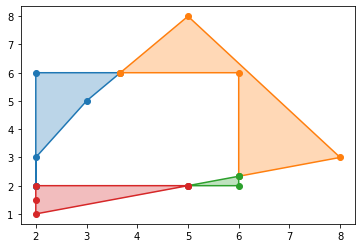

In [8]:
if __name__ == "__main__":
    # A = Trajectory([Point(16, 10), Point(18, 9), Point(19.3, 11), Point(20, 19), Point(22, 19), Point(23,21), Point(24, 21)])
    # B = Trajectory([Point(17, 15), Point(18, 16), Point(18, 19), Point(19,15), Point(21, 15), Point(21.2, 10), Point(26, 10)])

    A = Trajectory([Point(2, 2), Point(2, 6), Point(6, 6), Point(6, 2), Point(2, 2)])
    B = Trajectory([Point(2, 2), Point(2, 3), Point(3, 5), Point(5, 8), Point(8, 3), Point(2, 1)])
    A.error_with(B, display=True)